# Implementing Layer-wise Relevance Propagation for a simple MLP
This notebook loads MNIST data (60 000 images), builds and trains a simple MLP with layer sizes 784x300x100x10, and implements Layer-wise Relevance Propagation to construct a heatmap of the input pixels which supposedly have the most impact on the output.

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

### Load datset

In [2]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

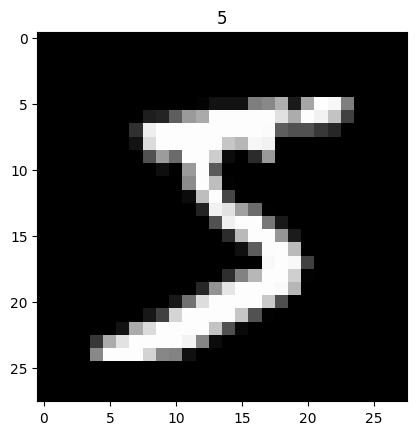

In [3]:
image, label = train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [5]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Train simple model

In [6]:
device = torch.device('mps')

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [8]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [9]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [10]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/3] Train loss: 0.35059 | Test loss: 0.14352, Test acc: 95.65%
[EPOCH 2/3] Train loss: 0.12251 | Test loss: 0.09492, Test acc: 96.90%
[EPOCH 3/3] Train loss: 0.08117 | Test loss: 0.07706, Test acc: 97.52%


### Layer-wise Relevance Propagation

#### Preparing for LRP

In [11]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L

3

In [12]:
X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

In [13]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [14]:
i = np.random.randint(0, 10)
prediction = A[L][i]
print(f"Pred: {np.argmax(prediction)} | Label: {train.targets[i]}")

Pred: 0 | Label: 0


#### Actual LRP

In [15]:
nb_digits = len(train.classes)
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

General rule for the hidden and output layers:
$$R_j = \sum_k \frac{a_j \rho(w_{jk})}{\epsilon + \sum_{0,j} a_j \rho(w_{jk})} R_k$$

In [16]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

Four steps of computing the relevance:
$$
\begin{align*}
\forall k:~z_k &= {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall k:~s_k &= R_k / z_k \qquad & (\text{step }2)\\
\forall j:~c_j &= {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall j:~R_j &= a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
$$

In [17]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

$z^\mathcal{B}$ rule for the input layer:
$$R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j$$

In [18]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

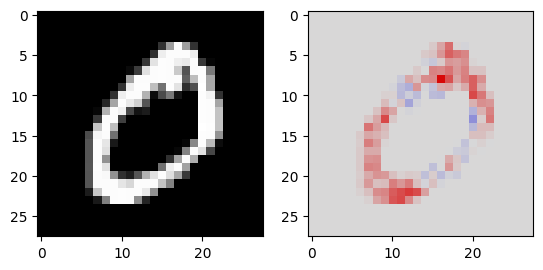

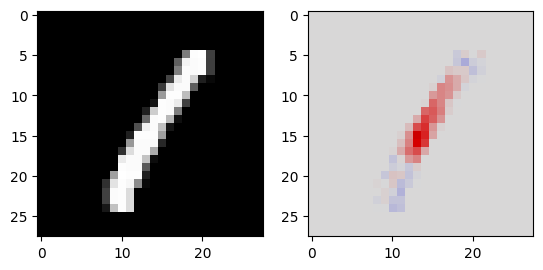

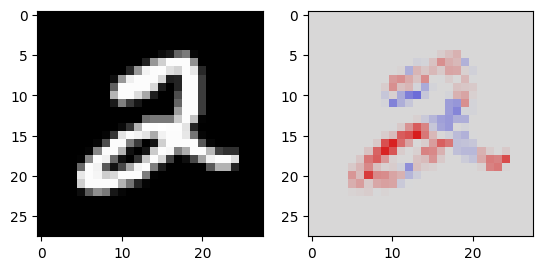

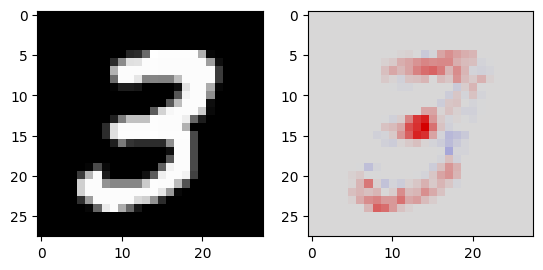

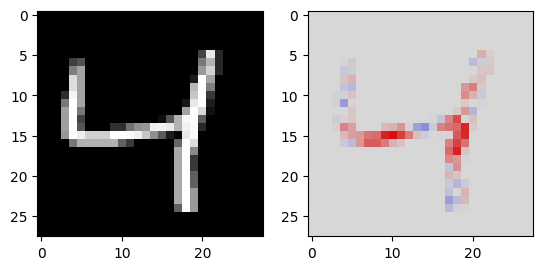

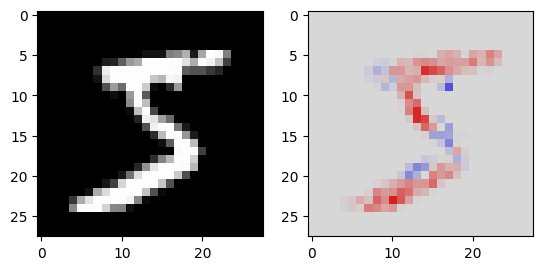

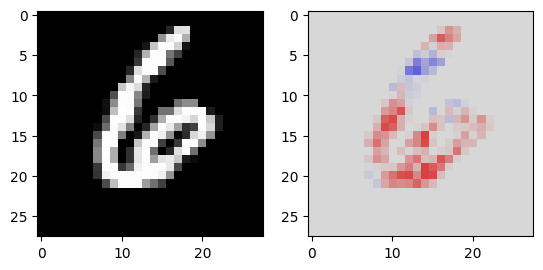

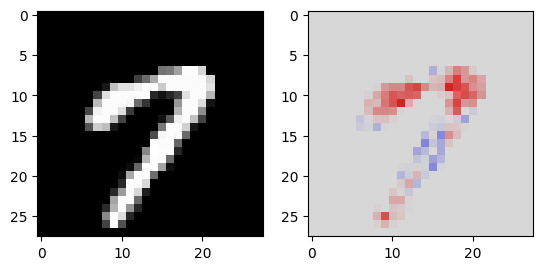

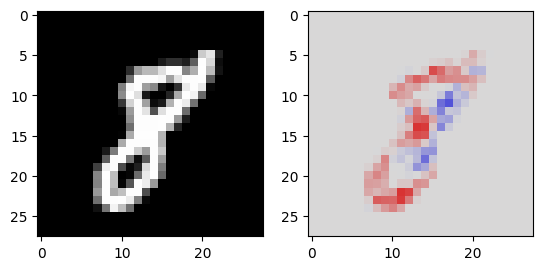

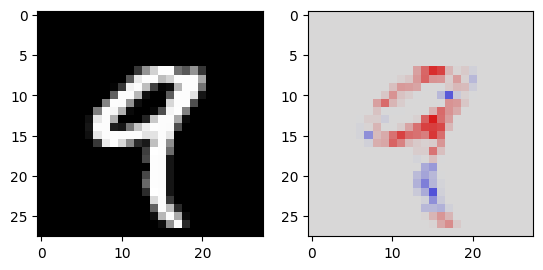

In [19]:
for i in range(10):
    image = R[0][T==i][0].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    plt.show()

Experimentation: apply a threshold to the heatmap.

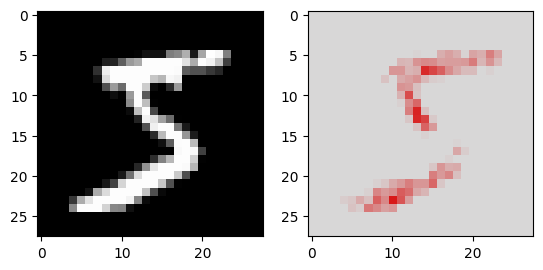

In [20]:
i = 0
image = R[0][i].reshape((28, 28))
threshold = 4
condition = image < threshold
image_t = np.copy(image)
image_t[condition] = np.zeros_like(image[condition])

b = 10*(np.abs(image_t)**3.0).mean()**(1.0/3)

my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
fig, axs = plt.subplots(1, 2)

axs[0].imshow(X[i].reshape((28, 28)), cmap="gray")
axs[1].imshow(image_t,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
plt.show()

### Average relevance over class

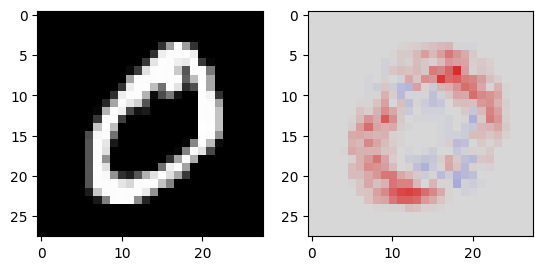

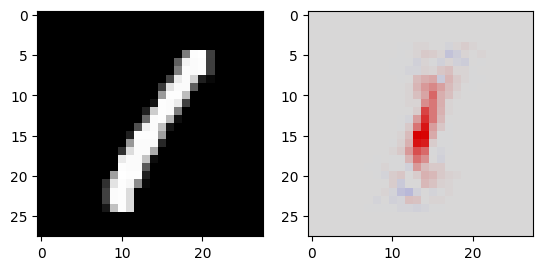

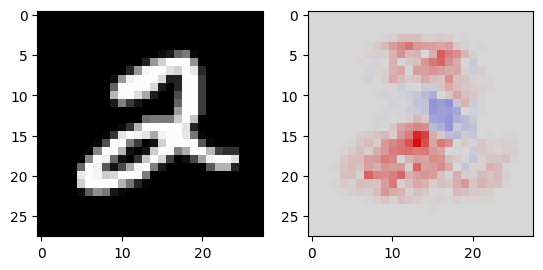

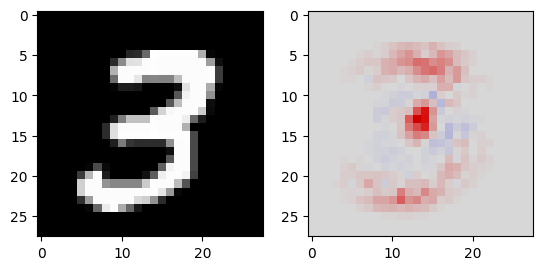

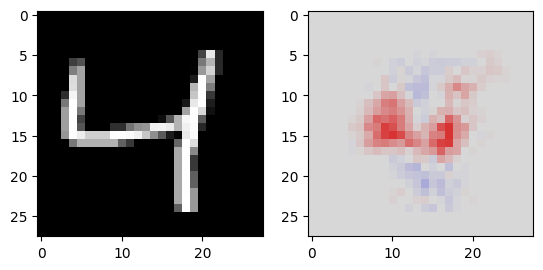

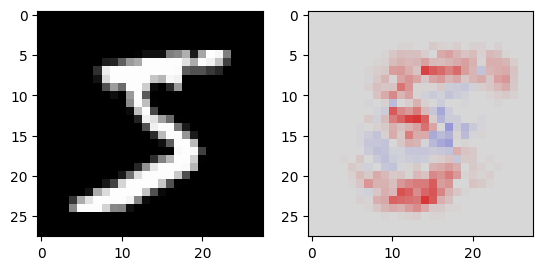

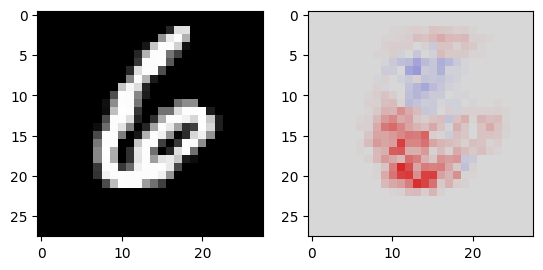

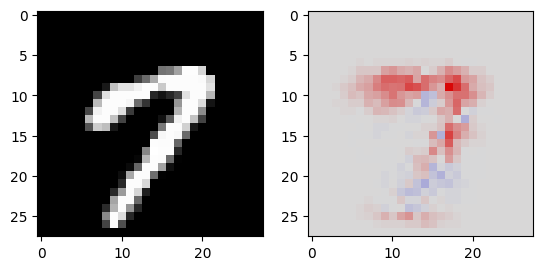

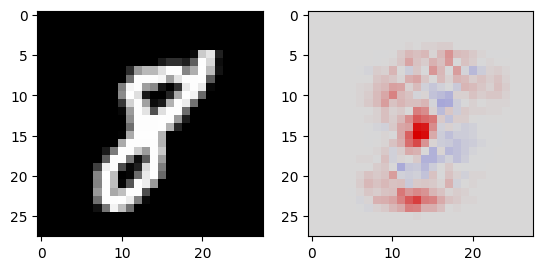

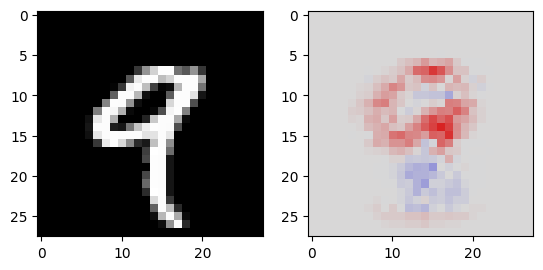

In [21]:
for i in range(nb_digits):
    selected = R[0][T==i]
    image = selected.reshape((selected.shape[0], 28, 28))
    image = np.mean(image, axis=0)

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    plt.show()

### Comparaison of LRP methods
Below, we use LRP-0 instead of Composite-LRP, and compare the two methods.

In [22]:
R_bis = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

In [23]:
def rho_bis(w,l):  return w #+ [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr_bis(z,l): return z #+ [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [24]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho_bis(W[l], l)
    b = incr_bis(B[l], l)

    z = incr_bis(A[l].dot(w)+b, l)
    s = R_bis[l+1] / z
    c = s.dot(w.T)
    R_bis[l] = A[l] * c

In [25]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_bis[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_bis[0] = A[0]*c - lb*cp - hb*cm

Average absolute relevance difference: 0.441
Normalized
 average absolute relevance difference: 0.71%


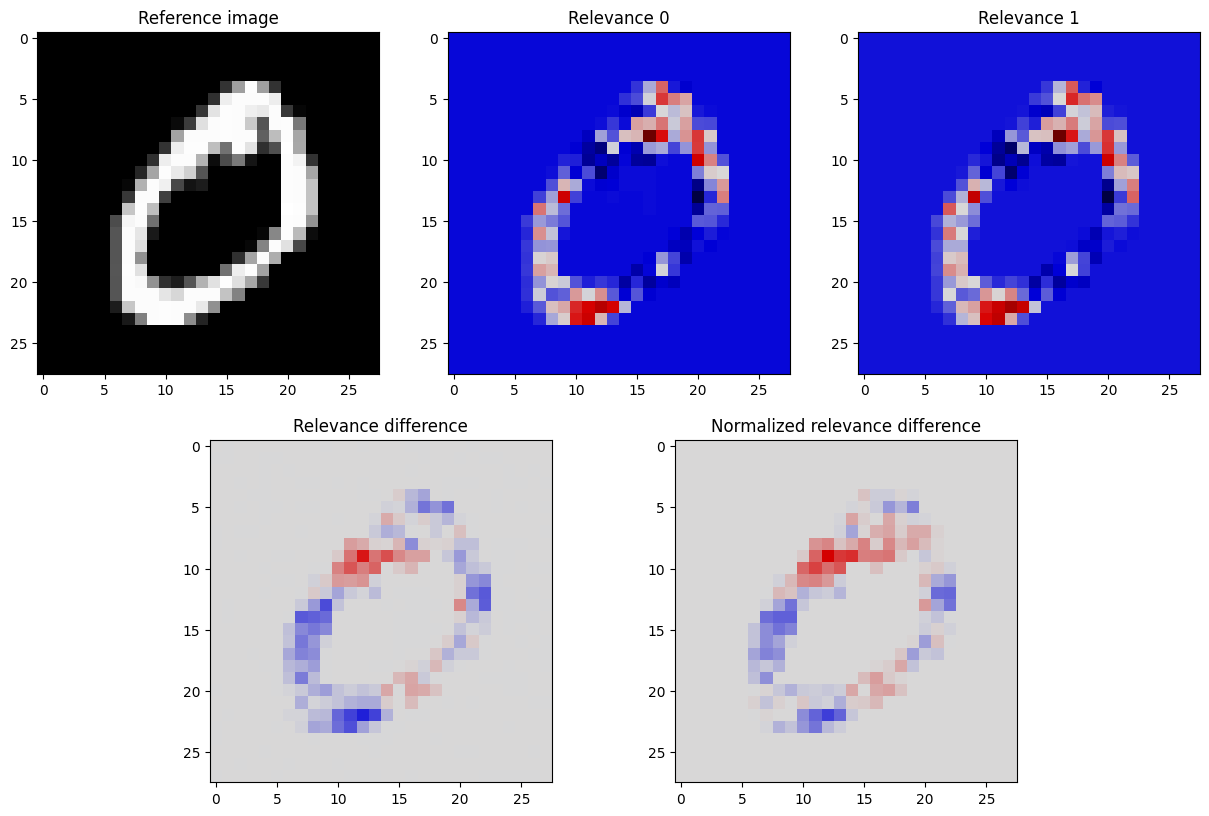

Average absolute relevance difference: 0.861
Normalized
 average absolute relevance difference: 2.15%


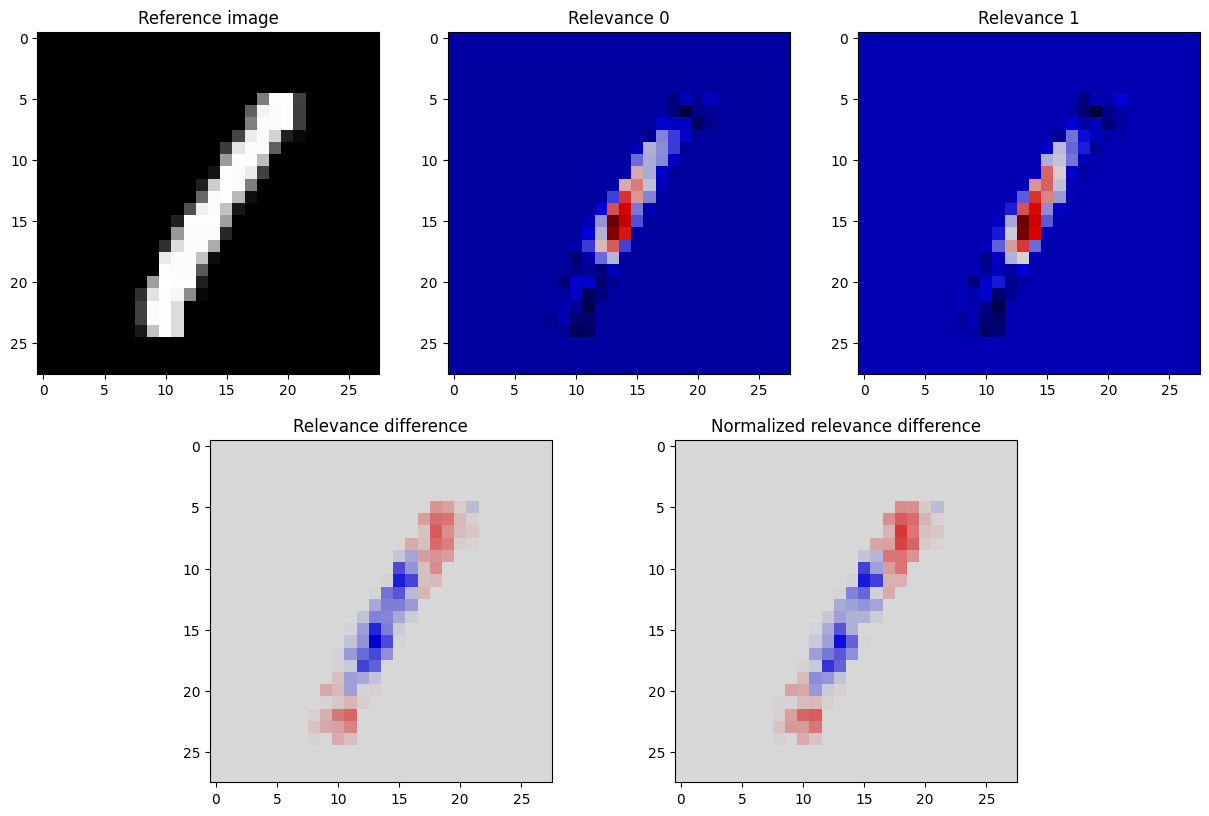

Average absolute relevance difference: 0.778
Normalized
 average absolute relevance difference: 1.63%


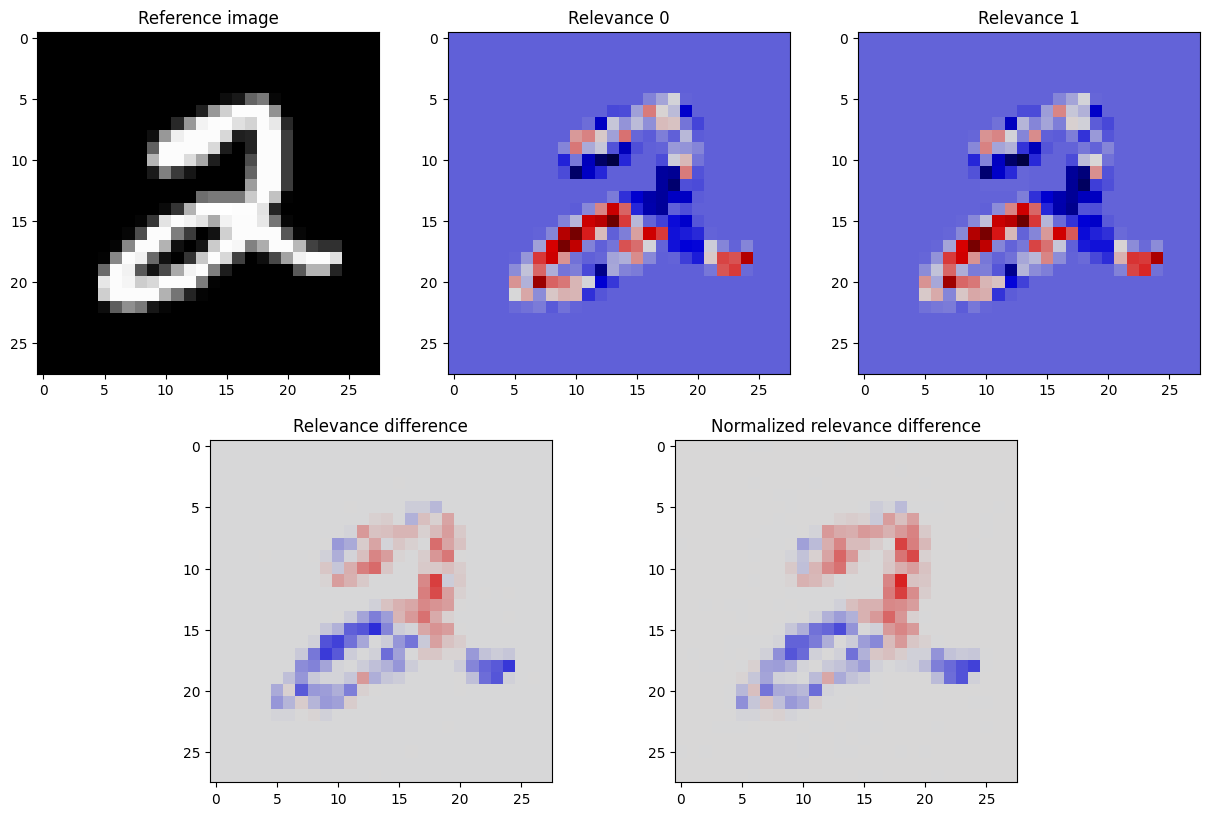

Average absolute relevance difference: 0.820
Normalized
 average absolute relevance difference: 1.08%


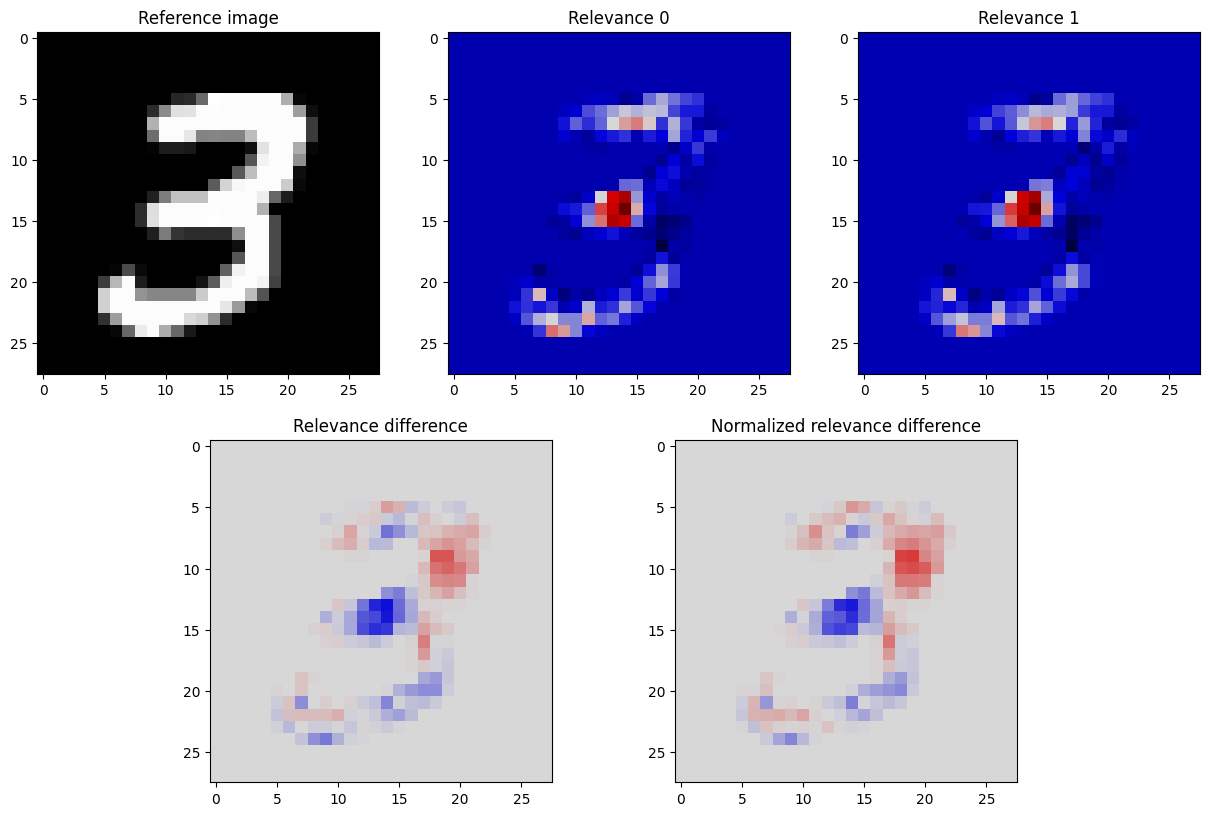

Average absolute relevance difference: 0.583
Normalized
 average absolute relevance difference: 2.03%


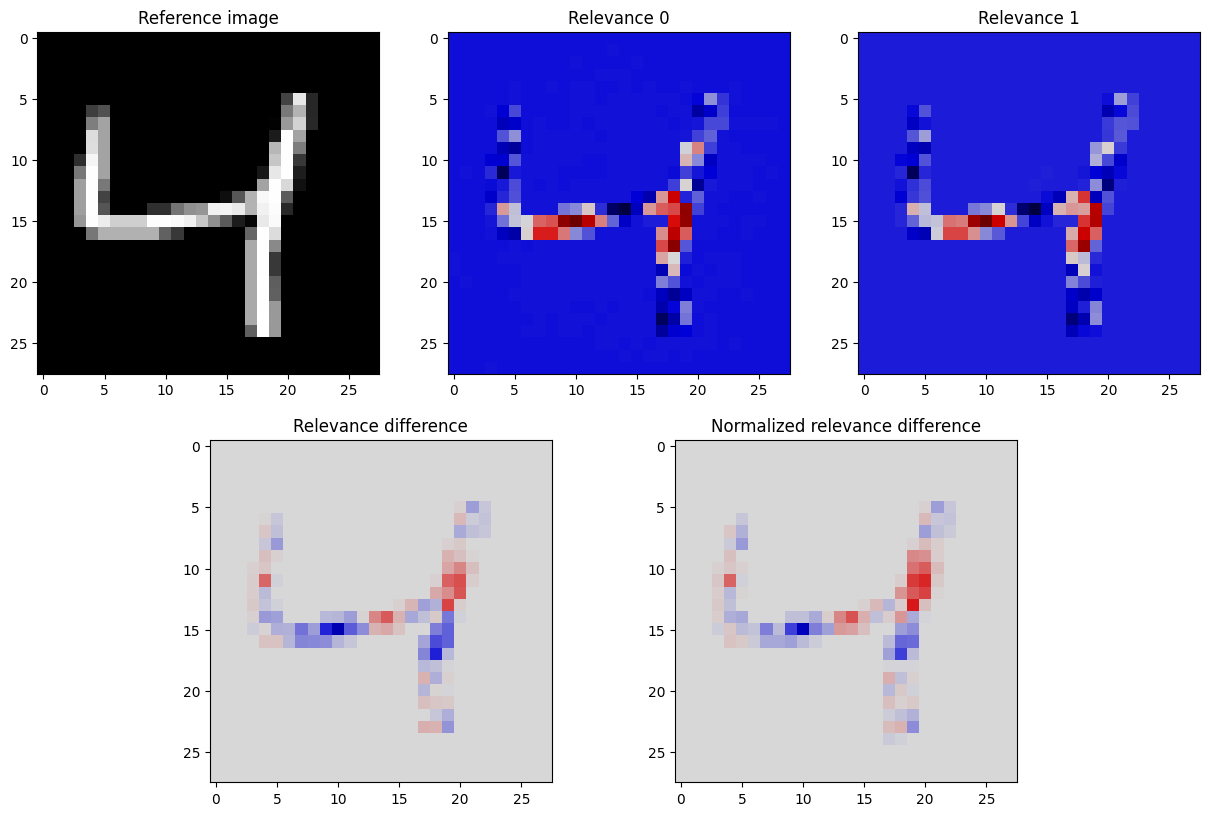

Average absolute relevance difference: 0.586
Normalized
 average absolute relevance difference: 0.88%


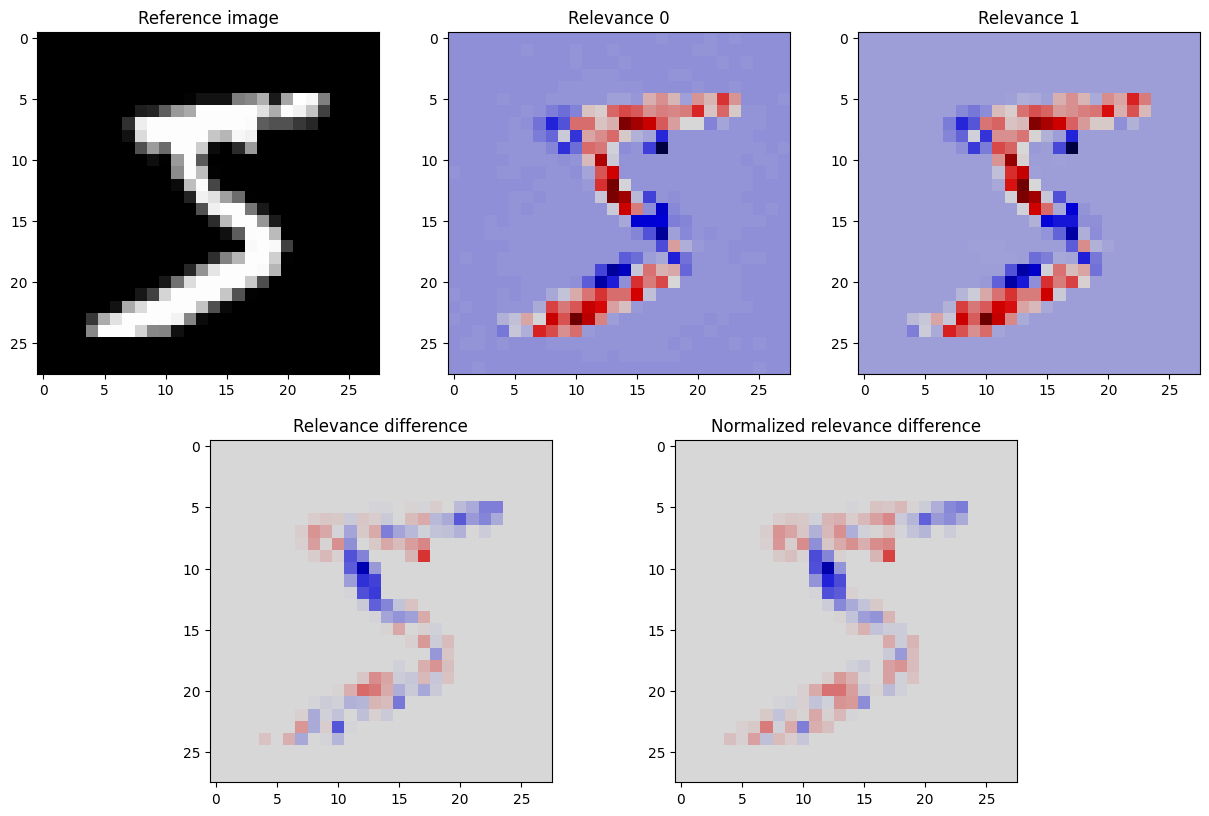

Average absolute relevance difference: 0.712
Normalized
 average absolute relevance difference: 1.53%


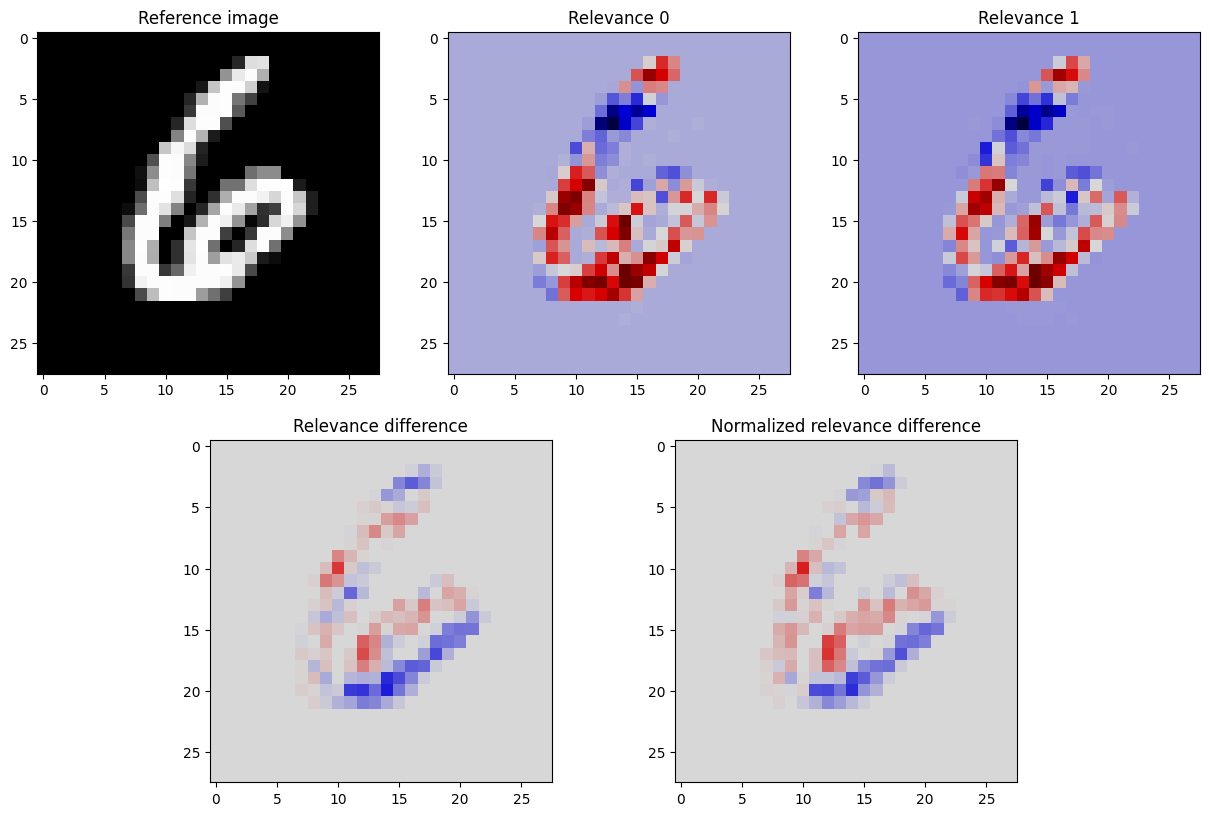

Average absolute relevance difference: 0.940
Normalized
 average absolute relevance difference: 1.65%


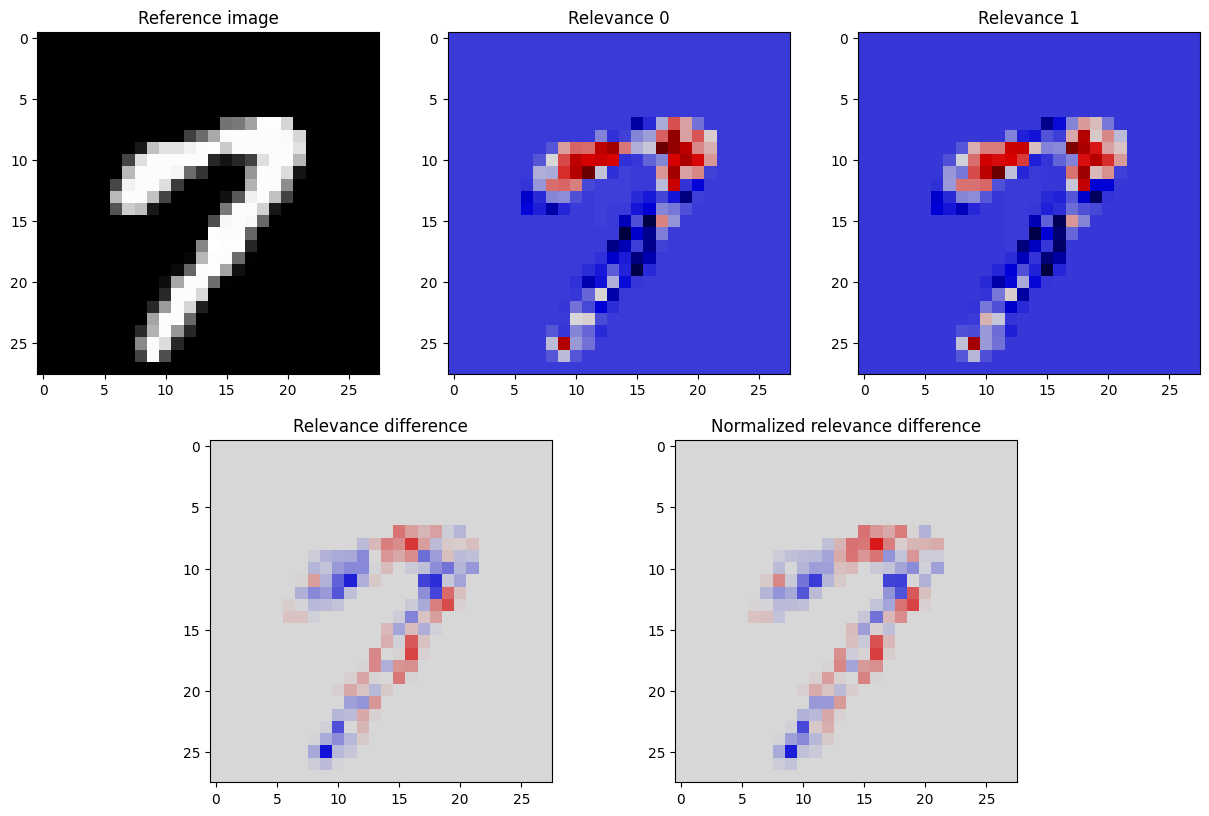

Average absolute relevance difference: 1.516
Normalized
 average absolute relevance difference: 2.59%


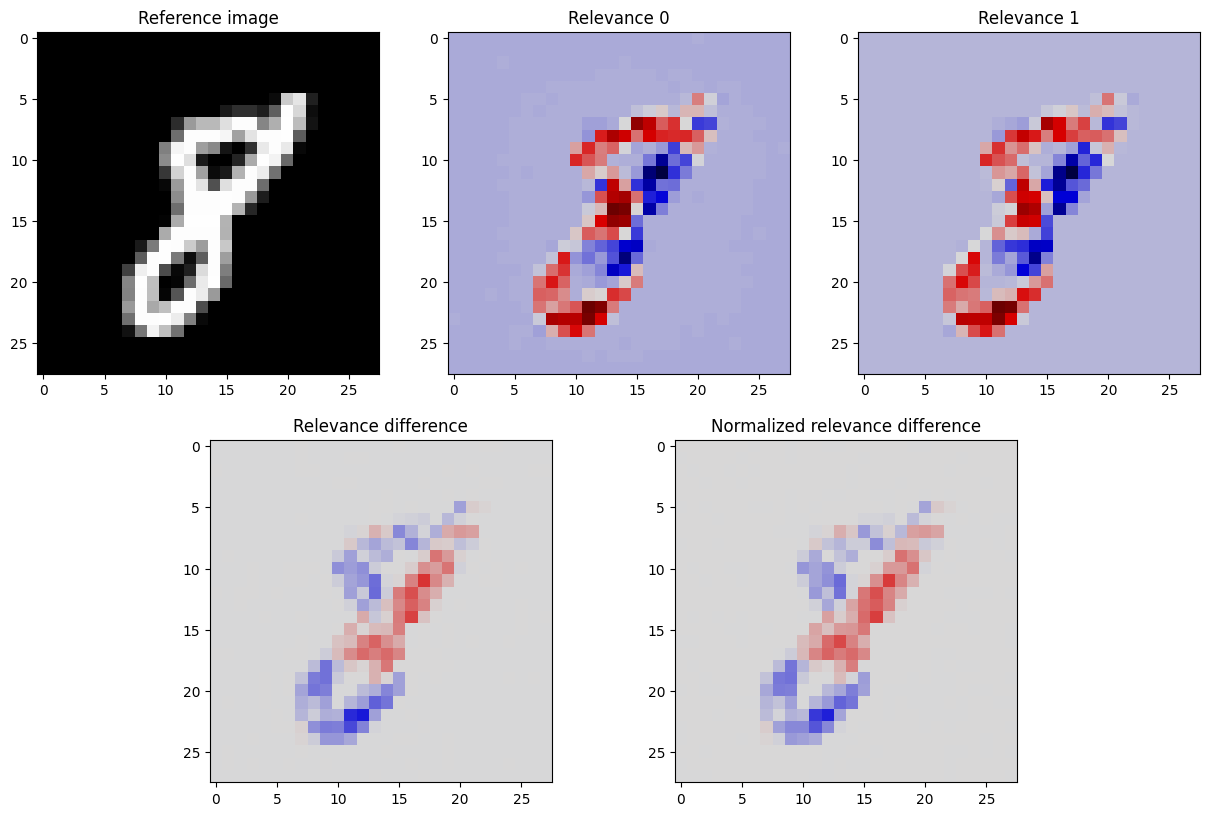

Average absolute relevance difference: 0.888
Normalized
 average absolute relevance difference: 1.85%


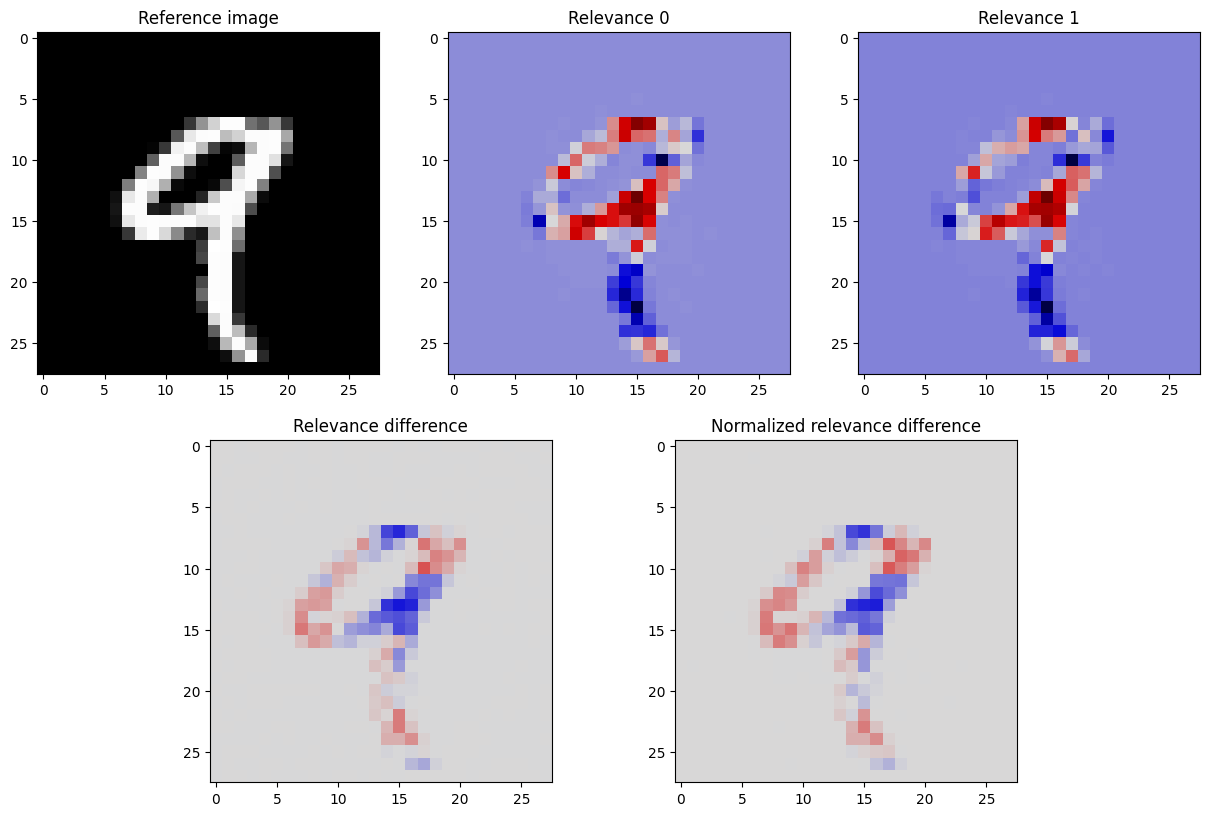

In [26]:
from relevancecmp import compare_relevance

for i in range(nb_digits):
    R0 = R[0][T==i][0]
    R1 = R_bis[0][T==i][0]

    reference = X[T==i][0]
    compare_relevance(reference, R0, R1, shape=(28, 28))